In [1]:
from src.utils.io import load_results
from matplotlib import pyplot as plt
import collections
import os
from collections import deque

import cv2
import numpy as np
import pandas as pd
import time
import zwoasi as asi

from src.camera.camera_setup import setup_camera
from src.camera.camera_stream import CameraStream
from src.camera.image_processing import get_clean_frame, \
    get_redness_frame, get_contours, get_contour_origin, get_largest_contour
from src.fsm.fsm_calibration import get_amplitude_per_pixel
from src.fsm.fsm_setup import setup_fsm
from src.utils.general import wait
from src.utils.io import save_results
from src.fsm.fsm import FSM
import random
root_dir = os.path.dirname(os.getcwd())
from src.utils.spectral_analysis import get_frequencies_and_amplitudes, get_distinct_peak_indices
from src.utils.general import show_images




### Camera Setup

In [2]:
BINS = 2
GAIN = 120
EXPOSURE = 32  # µs
RESOLUTION = (8288, 5640)
START_POS = (0, 0)
FRAMES_DARK = 10
BUFFER_CAPACITY = 1
COLOUR: bool = False
# Contour mode for finding center of brightest point, if false cv2.minMaxLox will be used
CONTOUR_MODE: bool = True
CAMERA_ID: int = 0
SDK_LIB_NAME: str = 'libASICamera2.dylib'
camera, master_dark = setup_camera(root_dir= root_dir,
                                      sdk_lib_name= SDK_LIB_NAME,
                                      camera_id= CAMERA_ID,
                                      bins=BINS,
                                      gain=GAIN,
                                      exposure=EXPOSURE,
                                      resolution= RESOLUTION,
                                      start_pos= START_POS,
                                      num_frames= FRAMES_DARK,
                                      colour=COLOUR)

Settings Reset to Default

ROI Set:
    Start X: 0
    Start Y: 0
    Resolution: 4144x2820
    Bins: 2

Using provided gain & exposure settings
Gain: 120, Exposure: 32µs

    AutoExpMaxExpMS
      - ControlType 11
      - DefaultValue 100
      - Description 'Auto exposure maximum exposure value(unit ms)'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 60000
      - MinValue 1
      - Name 'AutoExpMaxExpMS'
    AutoExpMaxGain
      - ControlType 10
      - DefaultValue 285
      - Description 'Auto exposure maximum gain value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 570
      - MinValue 0
      - Name 'AutoExpMaxGain'
    AutoExpTargetBrightness
      - ControlType 12
      - DefaultValue 100
      - Description 'Auto exposure target brightness value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 160
      - MinValue 50
      - Name 'AutoExpTargetBrightness'
    BandWidth
      - ControlType 6
      - Defau

### Testing movement of FSM laser point

In [14]:
PORT: str = "/dev/cu.usbserial-249WO6MO"
BAUDRATE: int = 115200
TIMEOUT: int = 1
fsm_controller = setup_fsm(PORT, BAUDRATE, TIMEOUT)

origin_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
origin_image = np.median(origin_frames, axis = 0).astype(np.uint8)


o_contours = get_contours(origin_image)
o_largest_contour = get_largest_contour(o_contours)
origin_x, origin_y = get_contour_origin(o_largest_contour)

origin_image = cv2.cvtColor(origin_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    image=origin_image,
    contours=o_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=origin_image,
    center=(int(origin_x), int(origin_y)),
    radius=20,
    color=(255, 0, 0),
    thickness=-1
)

fsm_controller.send_command(f"control strategy feedforward")
amplitude = 0.25
fsm_controller.send_command(f"signal generate -a y -w dc -A {amplitude}")


calibrate_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
calibrate_image = np.median(calibrate_frames, axis = 0).astype(np.uint8)

fsm_controller.send_command(f"control strategy off")


c_contours = get_contours(calibrate_image)
c_largest_contour = get_largest_contour(c_contours)
calibrate_x, calibrate_y = get_contour_origin(c_largest_contour)

calibrate_image = cv2.cvtColor(calibrate_image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(
    image=calibrate_image,
    contours=c_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=calibrate_image,
    center=(int(calibrate_x), int(calibrate_y)),
    radius=20,
    color=(255, 0 ,0),
    thickness=-1
)

delta_x = abs(origin_x - calibrate_x)
delta_y = abs(origin_y - calibrate_y)

if delta_x == 0:
    delta_x += 1
amplitude_per_pixel_x: float = amplitude / delta_x
amplitude_per_pixel_y: float = amplitude / delta_y

show_images(origin_image, calibrate_image, )
print(f"ORi, X: {origin_x} Y: {origin_y}"
      f"CAL, X: {calibrate_x} Y: {calibrate_y}")
camera.stop_video_capture()
camera.close()

Error: [Errno 2] could not open port /dev/cu.usbserial-249WO6MO: [Errno 2] No such file or directory: '/dev/cu.usbserial-249WO6MO', Failed to connect to port /dev/cu.usbserial-249WO6MO
Not connected to FSM
Not connected to FSM
Not connected to FSM


ZWO_IOError: Camera closed

### Recreation of movement noise

Loaded square_A1.0Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-24
Samples: 3142
Time: 180.00552892684937


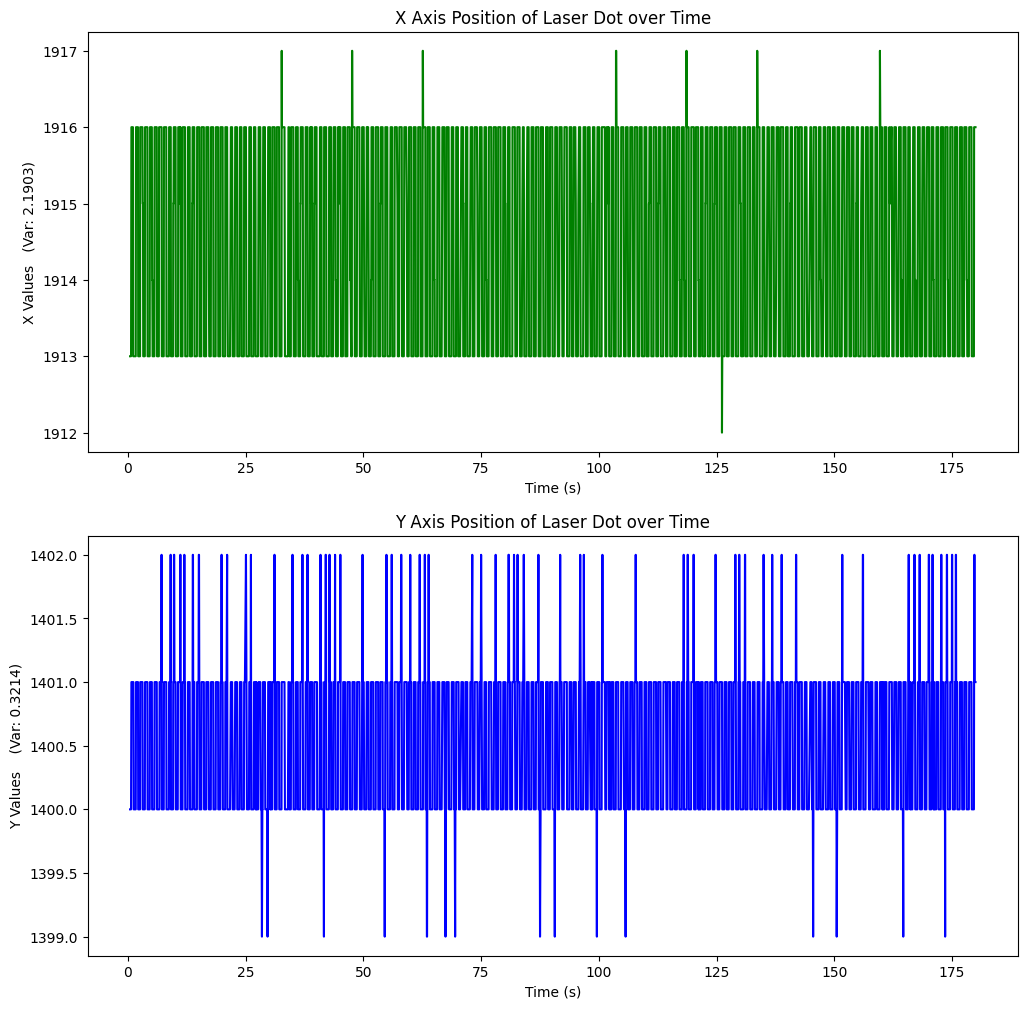

In [3]:
root_dir = os.path.dirname(os.getcwd())
results = load_results(root_dir, "square_A1.0Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-24")
time_results = results["Time"]
x_results = results["X"]
y_results = results["Y"]
print(f"Samples: {len(results)}")
print(f"Time: {max(time_results)}")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(time_results, x_results,color="g")
axes[0].set_title(f"X Axis Position of Laser Dot over Time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel(f"X Values   (Var: {x_results.var():.4f})")


axes[1].plot( results["Time"], y_results, label=f"Variance {y_results.var()}",  color="b")
axes[1].set_title(f"Y Axis Position of Laser Dot over Time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel(f"Y Values    (Var: {y_results.var():.4f})")

plt.show()


### Extracting predicted frequency of movement noise aswell as distinct frequencys

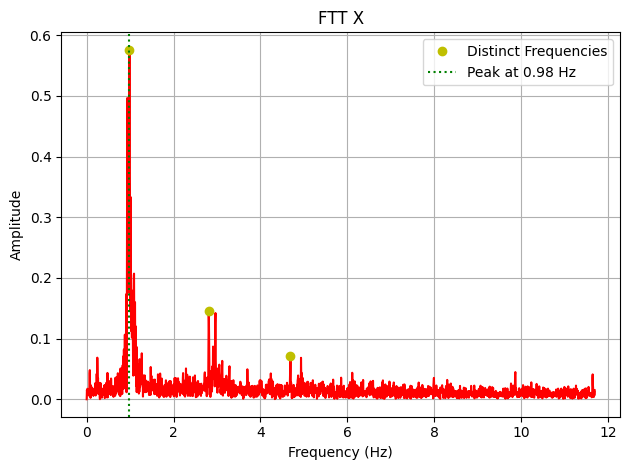

In [31]:
num_std_devs = 1
height = 0.5
x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(x_results, np.array(time_results))
x_dominant_frequency = x_frequencies[np.argmax(x_amplitudes)]
x_distinct_peak_indices = get_distinct_peak_indices(x_frequencies, x_amplitudes, num_std_devs, height)
plt.plot(x_frequencies, x_amplitudes,  color='r')
plt.plot(x_frequencies[x_distinct_peak_indices], x_amplitudes[x_distinct_peak_indices],  'yo', label= "Distinct Frequencies")

plt.title('FTT X')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(x_dominant_frequency, color='g', linestyle=':', label=f'Peak at {x_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

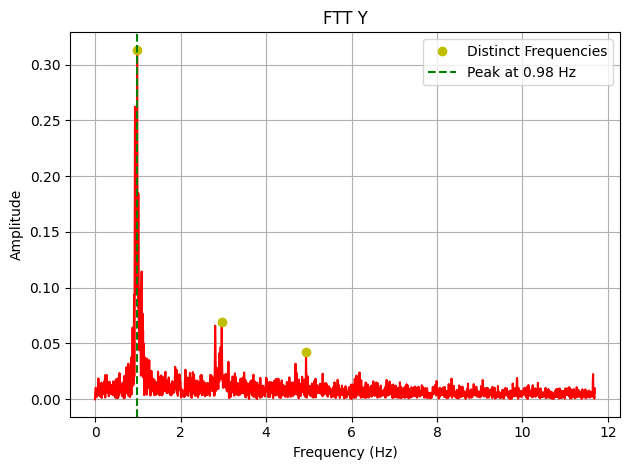

In [32]:
y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(y_results, np.array(time_results))
y_dominant_frequency = y_frequencies[np.argmax(y_amplitudes)]
y_distinct_peak_indices = get_distinct_peak_indices(y_frequencies, y_amplitudes, num_std_devs, height)
plt.plot(y_frequencies, y_amplitudes,  color='r')
plt.plot(y_frequencies[y_distinct_peak_indices], y_amplitudes[y_distinct_peak_indices],  'yo'
         ,label= "Distinct Frequencies")

plt.title('FTT Y')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(y_dominant_frequency, color='g', linestyle='--', label=f'Peak at {y_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

### Error of actual frequency of movement noise and predicted frequency of noise

In [37]:
actual_frequency = 1.0
dominant_frequency = (x_dominant_frequency + y_dominant_frequency) / 2
error = (abs(dominant_frequency - actual_frequency) / actual_frequency) * 100
print(f"Error: {error:.2f}%")

Error: 48.21%


### Intensity varation with power of laser

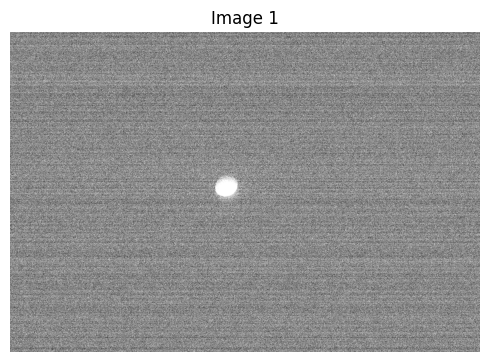

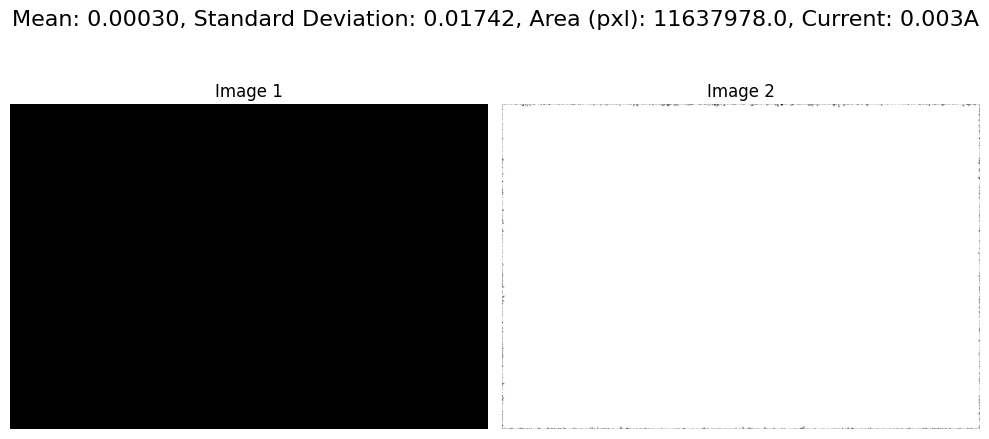

In [3]:
current = 0.003
current_unit: str = "A"
frames = 10
clean_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(frames)]
clean_image = np.median(clean_frames, axis = 0).astype(np.uint8)
contours = get_contours(clean_image)
if contours:
    lazer_blob = get_largest_contour(contours)
    mask = np.zeros(clean_image.shape, dtype=np.uint8)
    cv2.drawContours(mask,
                     [lazer_blob],
                     -1,
                     255,
                     thickness=cv2.FILLED)
    area = cv2.contourArea(lazer_blob) # Measured in pixels
    mean, std_dev = cv2.meanStdDev(clean_image, mask=mask)
    show_images(clean_image, mask, title= f"Mean: {mean[0,0]:.5f}, Standard Deviation: {std_dev[0,0]:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")
else:
    area = 0.0
    mean = 0.0
    std_dev = 0.0
    show_images(clean_image, title= f"Couldn't find any contours, Mean: {mean:.5f}, Standard Deviation: {std_dev:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")

### Intensity Results

In [4]:
camera.close()

In [66]:
error, mean, std_dev, current, area

(np.float64(48.207868486313856), 0.0, 0.0, 0.001, 0.0)

In [118]:
intensity_results = pd.DataFrame({
    "Frequency Error" : [
        48.2079, 71.3417, 74.1141, 3.017, 5.4405,
        4.2509, 0.7987, 4.1856, 2.6212, 1.2864,
        2.0884, 2.8698, 0.0767, 8.2045, 3.1407

    ],
    "Mean Intensity" : [
        0.0, 0.0, 0.0, 0.9962, 1.3467,
        2.6624, 9.1747, 19.4470, 34.7310, 52.8142,
        78.3584, 111.0976, 156.9581, 184.3910, 205.3289

    ],
    "Standard Deviation Intensity" : [
        0.0, 0.0, 0.0, 0.0613, 0.5073,
        0.7638, 3.4061, 7.5715, 12.5792, 20.0336,
        29.5215, 42.8003, 57.7703, 58.9460, 53.4733

    ],
    f"Current (A)" : [
        0.0, 0.001, 0.002, 0.003, 0.004,
        0.005, 0.01, 0.015, 0.02, 0.025,
        0.03, 0.035, 0.04, 0.045, 0.05

    ],
    f"Area (pxl)" : [
        0.0, 0.0, 0.0, 2021.0, 5292.0,
        4168.0, 6281.5, 6855.5, 6415.0, 6812.0,
        6810.5, 7013.0, 7178.0, 8979.5, 11202.0
    ]
})

### Measuring optical power with current

In [119]:
# At a power of 0.0 uW the current is also 0.0 A

power_current_measurements = pd.DataFrame({
    "Power (uW)" : [
        0.00348, 0.01442, 0.0338, 0.0578,
        0.0895, 0.317, 0.652, 1.106, 1.718,
        2.55, 13.82, 8.47, 5.55, 3.74
    ],
    f"Current (A)" : [
        0.001, 0.002, 0.003, 0.004,
        0.005, 0.01, 0.015, 0.02, 0.025,
        0.03, 0.035, 0.04, 0.045, 0.05
    ],
})
n = len(power_current_measurements)
k = sum([
    (power_current_measurements["Power (uW)"][i] / power_current_measurements["Current (A)"][i])
    for i in range(n)
]) / n
print(f"Constant: {k: .6f}")

Constant:  81.659558


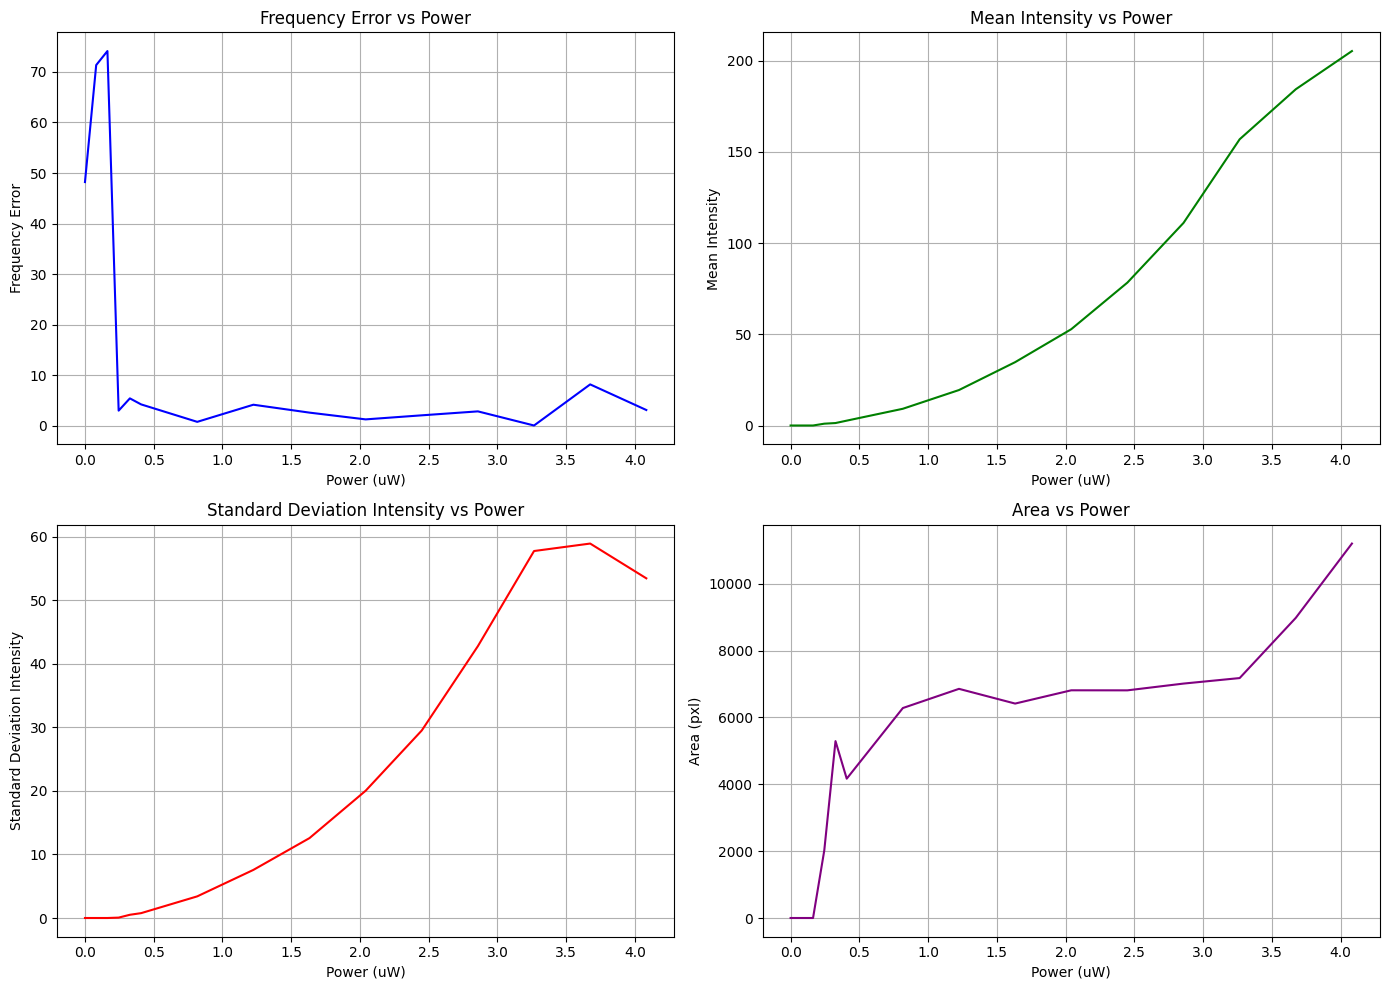

In [120]:
power = True

x_axis_unit = "uW" if power else "A"
x_axis_label= "Power" if power else "Current"
x_axis_data = intensity_results["Current (A)"] * k
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(x_axis_data, intensity_results["Frequency Error"], color='blue')
axes[0, 0].set_title(f"Frequency Error vs {x_axis_label}")
axes[0, 0].set_ylabel("Frequency Error")
axes[0, 0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0, 0].grid(True)

axes[0, 1].plot(x_axis_data, intensity_results["Mean Intensity"], color='green')
axes[0, 1].set_title(f"Mean Intensity vs {x_axis_label}")
axes[0, 1].set_ylabel("Mean Intensity")
axes[0, 1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0, 1].grid(True)

axes[1, 0].plot(x_axis_data, intensity_results["Standard Deviation Intensity"], color='red')
axes[1, 0].set_title(f"Standard Deviation Intensity vs {x_axis_label}")
axes[1, 0].set_ylabel("Standard Deviation Intensity")
axes[1, 0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1, 0].grid(True)

axes[1, 1].plot(x_axis_data, intensity_results["Area (pxl)"], color='purple')
axes[1, 1].set_title(f"Area vs {x_axis_label}")
axes[1, 1].set_ylabel("Area (pxl)")
axes[1, 1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


### Plots that are independent of the area of the lazer

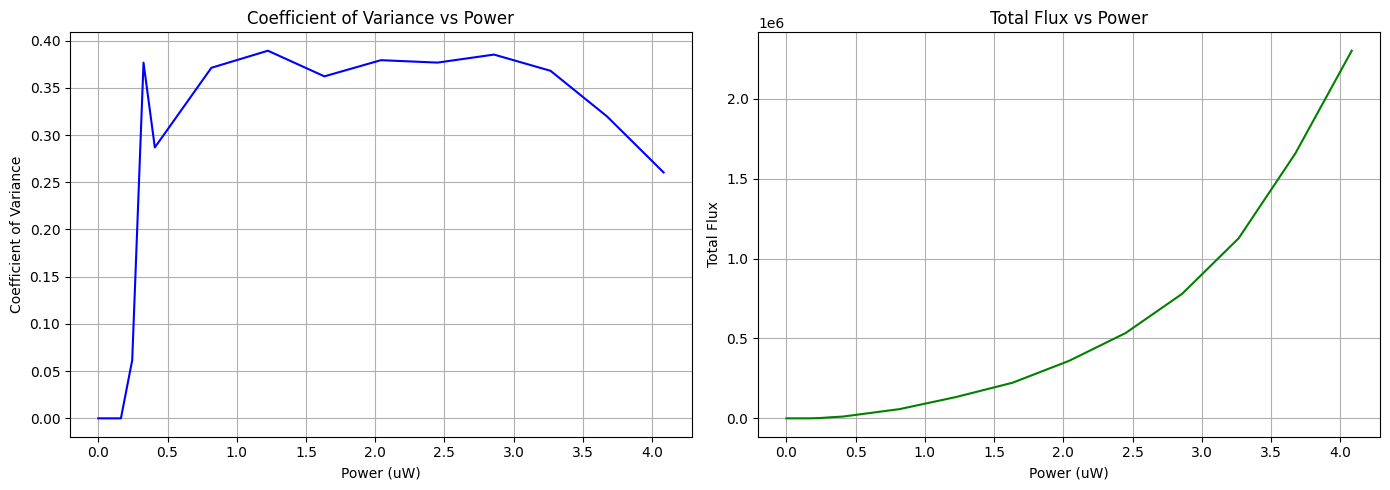

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

coefficient_of_variance = intensity_results["Standard Deviation Intensity"] / (intensity_results["Mean Intensity"] + 1e-9)
axes[0].plot(x_axis_data, coefficient_of_variance, color='blue')
axes[0].set_title(f"Coefficient of Variance vs {x_axis_label}")
axes[0].set_ylabel("Coefficient of Variance")
axes[0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0].grid(True)

total_flux = intensity_results["Mean Intensity"] * intensity_results["Area (pxl)"]
axes[1].plot(x_axis_data, total_flux, color='green')
axes[1].set_title(f"Total Flux vs {x_axis_label}")
axes[1].set_ylabel("Total Flux")
axes[1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Testing how frequency changes over time with amplitude

In [44]:
results_2 = load_results(root_dir, "square_A1.0Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_1_75 = load_results(root_dir, "square_A1.75Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_1_5 = load_results(root_dir, "square_A1.5Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_1_25 = load_results(root_dir, "square_A1.25Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_1 = load_results(root_dir, "square_A1.0Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_0_75 = load_results(root_dir, "square_A.75Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_0_5 = load_results(root_dir, "square_A.5Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_0_25 = load_results(root_dir, "square_A.25Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_0_15 = load_results(root_dir, "square_A.15Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_0_05 = load_results(root_dir, "square_A.05Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_0_025 = load_results(root_dir, "square_A.025Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")
results_0_001 = load_results(root_dir, "square_A.001Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-25")

dict_results = {2.0 : results_2,
                1.75 : results_1_75,
                1.5 : results_1_5,
                1.25 : results_1_25,
                1.0 : results_1,
                0.75 : results_0_75,
                0.5 : results_0_5,
                0.25 : results_0_25,
                0.15 : results_0_15,
                0.05 : results_0_05,
                0.025 : results_0_025,
                0.001 : results_0_001}

Loaded square_A1.0Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-25
Loaded square_A1.75Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-25
Loaded square_A1.5Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-25
Loaded square_A1.25Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-25
Loaded square_A1.0Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-25
Loaded square_A.75Vpp_.04A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU

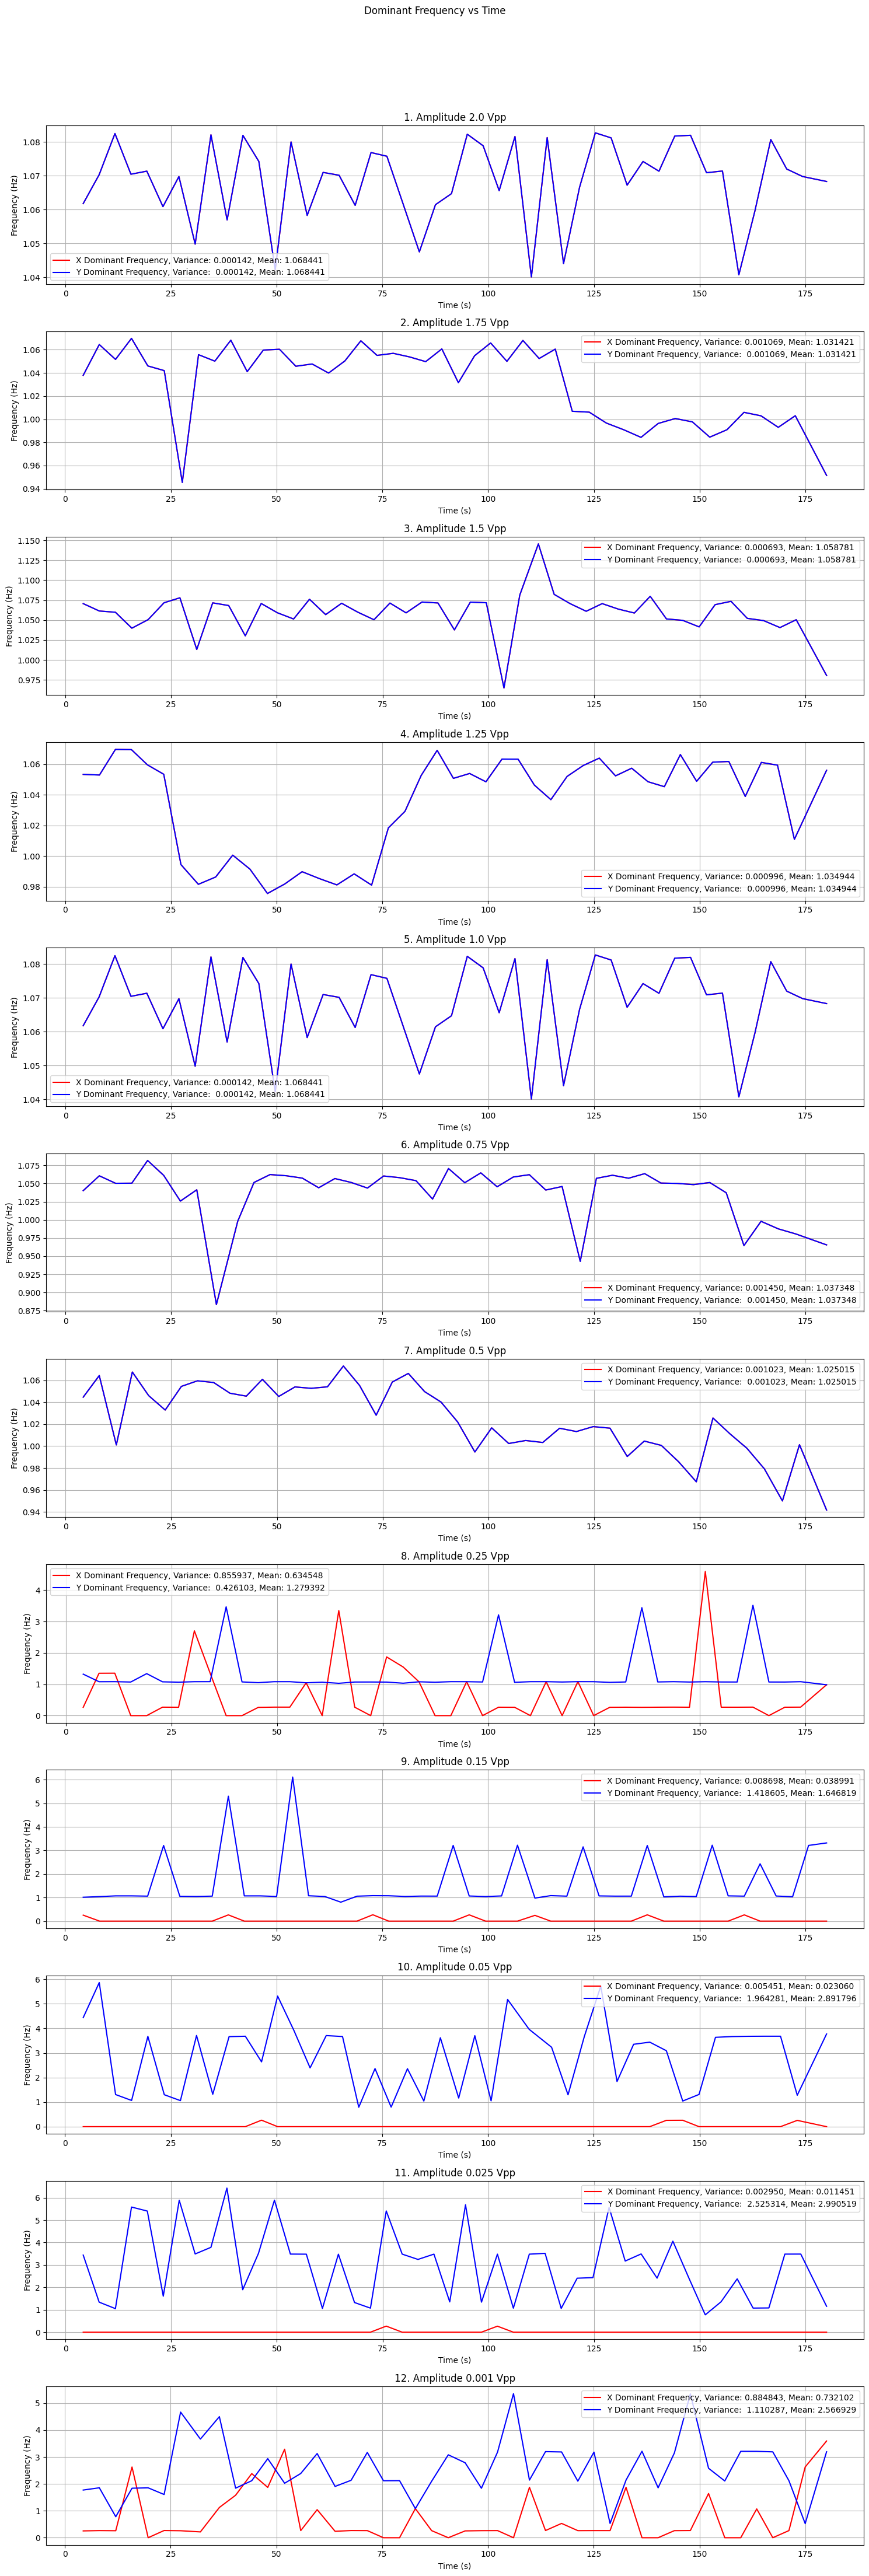

In [45]:
window_size = 100
dict_final_results = {}
for r_key in dict_results.keys():
    final_results = []
    r = dict_results[r_key]
    x_results = np.array(r["X"])
    y_results = np.array(r["Y"])
    times = np.array(r["Time"])
    for i in range(len(r) // window_size):
        start_idx = i * window_size
        if (i + 1) < len(r) // window_size:
            end_idx = start_idx + window_size
        else:
            end_idx = len(r) - 1
        x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(np.array(x_results[start_idx:end_idx]), np.array(times[start_idx:end_idx]))
        y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(np.array(y_results[start_idx:end_idx]), np.array(times[start_idx:end_idx]))
        final_results.append(
            (x_frequencies[np.argmax(x_amplitudes)],
             y_frequencies[np.argmax(y_amplitudes)],
             times[end_idx])
        )
    dict_final_results[r_key] = final_results

fig, axes = plt.subplots(len(dict_final_results), 1 , figsize=(15, 45))

for i, final_result_key in enumerate(dict_final_results.keys()):
    final_result = dict_final_results[final_result_key]
    x_dominant_frequencies, y_dominant_frequencies, times = zip(*final_result)
    x_variance = np.var(x_dominant_frequencies)
    y_variance = np.var(y_dominant_frequencies)
    x_mean = np.mean(x_dominant_frequencies)
    y_mean = np.mean(y_dominant_frequencies)
    axes[i].set_title(f"{i+1}. Amplitude {final_result_key} Vpp")

    axes[i].plot(times, x_dominant_frequencies, color='r', label=f'X Dominant Frequency, Variance: {x_variance:.6f}, Mean: {x_mean:.6f}')
    axes[i].plot(times, y_dominant_frequencies, color='b', label=f'Y Dominant Frequency, Variance: {y_variance: .6f}, Mean: {y_mean:.6f}')

    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Dominant Frequency vs Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

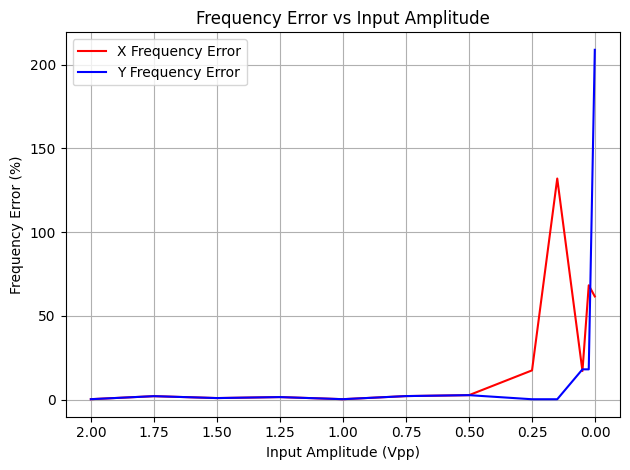

In [48]:
dict_final_results = {}
for r_key in dict_results.keys():
    r = dict_results[r_key]
    x_results = np.array(r["X"])
    y_results = np.array(r["Y"])
    times = np.array(r["Time"])
    x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(np.array(x_results), np.array(times))
    y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(np.array(y_results), np.array(times))

    dict_final_results[r_key] = (x_frequencies[np.argmax(x_amplitudes)],
         y_frequencies[np.argmax(y_amplitudes)],)

actual_frequency = 1.0
x_dominant_frequencies, y_dominant_frequencies = zip(*dict_final_results.values())
x_error = (abs(np.array(x_dominant_frequencies) - actual_frequency) / actual_frequency) * 100
y_error = (abs(np.array(y_dominant_frequencies) - actual_frequency) / actual_frequency) * 100

plt.plot(dict_final_results.keys(), x_error, color='r', label=f'X Frequency Error')
plt.plot(dict_final_results.keys(), y_error, color='b', label=f'Y Frequency Error')
plt.legend()
plt.gca().invert_xaxis()
plt.title("Frequency Error vs Input Amplitude")
plt.xlabel("Input Amplitude (Vpp)")
plt.ylabel("Frequency Error (%)")
plt.grid(True)
plt.tight_layout()
plt.show()